In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

In [2]:
# ground truth information - will pretend it's unknown
def f(x, params):
    return params[0] * np.sin(x[0]**2 + x[1]**2) - params[1] * np.cos(x[0]**2 + x[1]**2) + params[2]

gt_params = [2, 8, -5]

In [3]:
# region of interest
domain = [
        (0, 1),
        (-1, 1)
        ]

array([[-7.63947648e+00, -7.63935633e+00, -7.63899590e+00, ...,
         4.64892421e-02,  9.71852583e-02,  1.47769546e-01],
       [-7.76121577e+00, -7.76109627e+00, -7.76073778e+00, ...,
        -5.60230519e-02, -4.71536284e-03,  4.64892421e-02],
       [-7.88133041e+00, -7.88121159e+00, -7.88085511e+00, ...,
        -1.58920974e-01, -1.07018806e-01, -5.52111210e-02],
       ...,
       [-7.88133041e+00, -7.88121159e+00, -7.88085511e+00, ...,
        -1.58920974e-01, -1.07018806e-01, -5.52111210e-02],
       [-7.76121577e+00, -7.76109627e+00, -7.76073778e+00, ...,
        -5.60230519e-02, -4.71536284e-03,  4.64892421e-02],
       [-7.63947648e+00, -7.63935633e+00, -7.63899590e+00, ...,
         4.64892421e-02,  9.71852583e-02,  1.47769546e-01]])

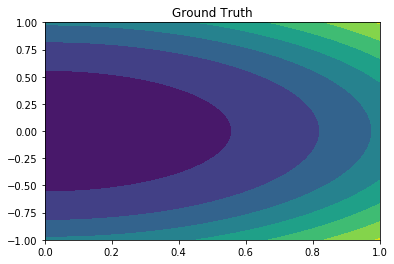

In [4]:
def plot_gt():
    n_steps = 256
    axes = [np.linspace(dim_low, dim_high, n_steps) for (dim_low, dim_high) in domain]
    xx, yy = np.meshgrid(axes[0], axes[1], sparse=True)
    zz = f([xx, yy], gt_params)
    h = plt.contourf(axes[0], axes[1], zz)
    return zz

plt.title('Ground Truth')
plot_gt()

In [5]:
def generate_X_uniform(n):
    coords = [np.random.uniform(dim_low, dim_high, (n,)) for (dim_low, dim_high) in domain]
    vals = f(coords, gt_params)
    return np.c_[coords[0], coords[1], vals].T

n_samples = 100
X = generate_X_uniform(n_samples)
print(X.shape)
print(X[:,:5])

(3, 100)
[[  0.37454012   0.95071431   0.73199394   0.59865848   0.15601864]
 [ -0.93714163   0.27282082  -0.37128804   0.01714138   0.81513295]
 [ -7.49438837  -7.80845634 -10.00458255 -11.78878381  -9.90496109]]


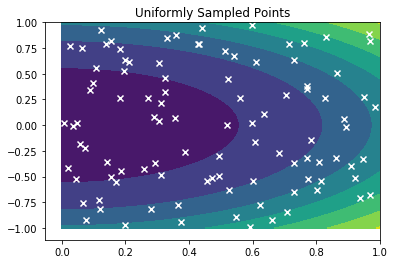

In [6]:
def plot_samples(X):
    plt.scatter(X[0,:], X[1,:], marker='x', c='w')

plt.title('Uniformly Sampled Points')
plot_gt()
plot_samples(X)

(3, 100)
[[ 0.          0.11111111  0.22222222  0.33333333  0.44444444]
 [-1.         -1.         -1.         -1.         -1.        ]
 [-7.63947648 -7.54282874 -7.25061936 -6.75694377 -6.05498076]]


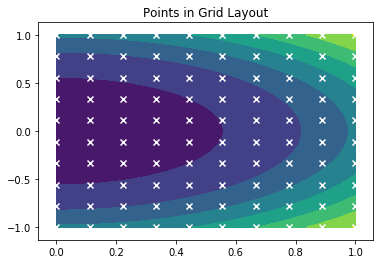

In [7]:
def generate_X_grid(n):
    n_steps = int(np.sqrt(n))
    axes = [np.linspace(dim_low, dim_high, n_steps) for (dim_low, dim_high) in domain]
    xx, yy = np.meshgrid(axes[0], axes[1])
    vals = f([xx, yy], gt_params)
    return np.c_[xx.ravel(), yy.ravel(), vals.ravel()].T

X = generate_X_grid(n_samples)
plt.title('Points in Grid Layout')
plot_gt()
plot_samples(X)

print(X.shape)
print(X[:,:5])

[0.0, 0.5, 0.25, 0.75, 0.125, 0.625, 0.375, 0.875, 0.0625, 0.5625]
[[0.5        0.33333333]
 [0.25       0.66666667]
 [0.75       0.11111111]
 [0.125      0.44444444]
 [0.625      0.77777778]]
(3, 100)
[[  0.5          0.25         0.75         0.125        0.625     ]
 [ -0.33333333   0.33333333  -0.77777778  -0.11111111   0.55555556]
 [-11.77741084 -12.53425866  -6.30057669 -12.9409367   -9.83519994]]


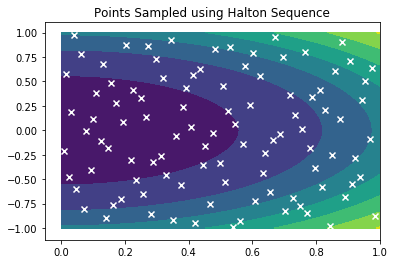

In [8]:
def generate_X_halton(n):
    from halton import halton
    coords = halton(2, n).T
    for (i, (dim_low, dim_high)) in zip(range(2), domain):
        coords[i,:] = dim_low + coords[i,:] * (dim_high - dim_low)
    vals = f([coords[0,:], coords[1,:]], gt_params)
    return np.c_[coords[0,:].ravel(), coords[1,:].ravel(), vals.ravel()].T

X = generate_X_halton(n_samples)
plt.title('Points Sampled using Halton Sequence')
plot_gt()
plot_samples(X)

print(X.shape)
print(X[:,:5])

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


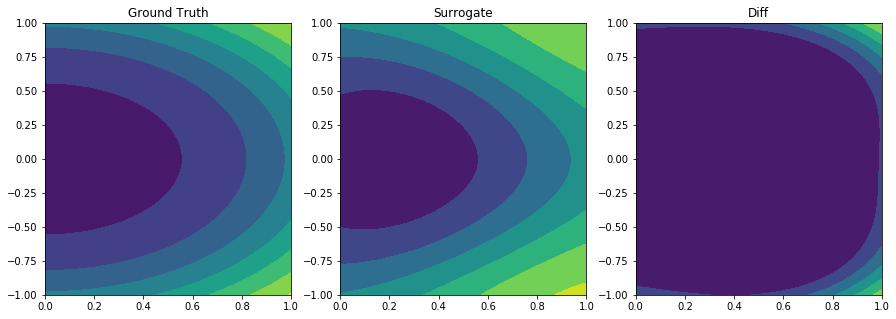

In [9]:
def train_svm(X):
    from sklearn.svm import SVR
    return SVR().fit(X[0:2,:].T, X[2,:])

def plot_reg(reg):
    n_steps = 256
    axes = [np.linspace(dim_low, dim_high, n_steps) for (dim_low, dim_high) in domain]
    xx, yy = np.meshgrid(axes[0], axes[1])
    zz = reg.predict(np.c_[xx.ravel(), yy.ravel()]).reshape((n_steps, n_steps))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    ax1 = plt.subplot(131)
    plt.title('Ground Truth')
    zz_gt = plot_gt()

    ax2 = plt.subplot(132, sharey=ax1)
    plt.title('Surrogate')
    h = plt.contourf(xx, yy, zz)

    ax2 = plt.subplot(133, sharey=ax2)
    plt.title('Diff')
    h = plt.contourf(xx, yy, np.abs(zz - zz_gt))

reg_svm = train_svm(X)
plot_reg(reg_svm)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


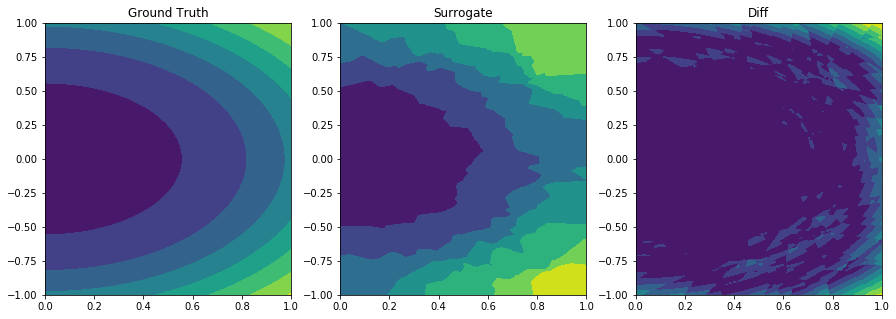

In [10]:
def train_knn(X):
    from sklearn.neighbors import KNeighborsRegressor
    return KNeighborsRegressor().fit(X[0:2,:].T, X[2,:])

reg_knn = train_knn(X)
plot_reg(reg_knn)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


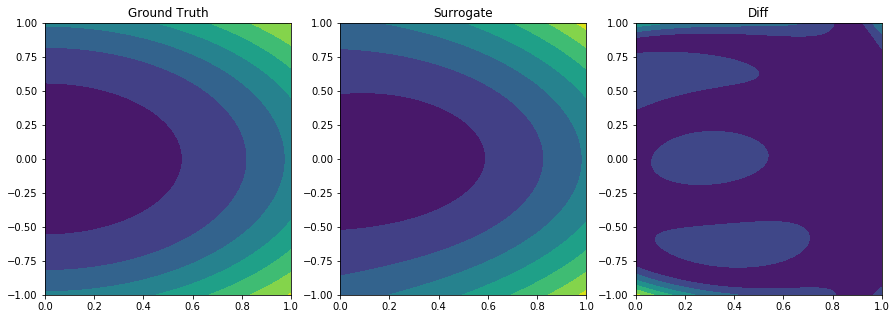

In [11]:
def train_poly_reg(X):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import Pipeline
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                      ('linear', LinearRegression(fit_intercept=False))])
    return model.fit(X[0:2,:].T, X[2,:])

reg_poly_reg = train_poly_reg(X)
plot_reg(reg_poly_reg)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


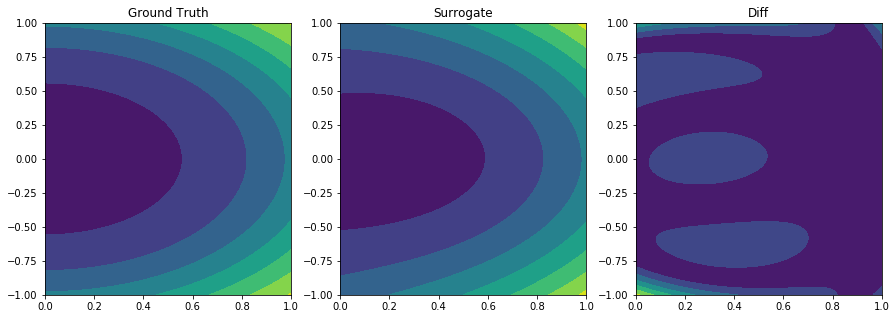

In [12]:
def train_poly_ridge(X):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import BayesianRidge
    from sklearn.pipeline import Pipeline
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                      ('linear', BayesianRidge())])
    return model.fit(X[0:2,:].T, X[2,:])

reg_poly_ridge = train_poly_ridge(X)
plot_reg(reg_poly_ridge)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


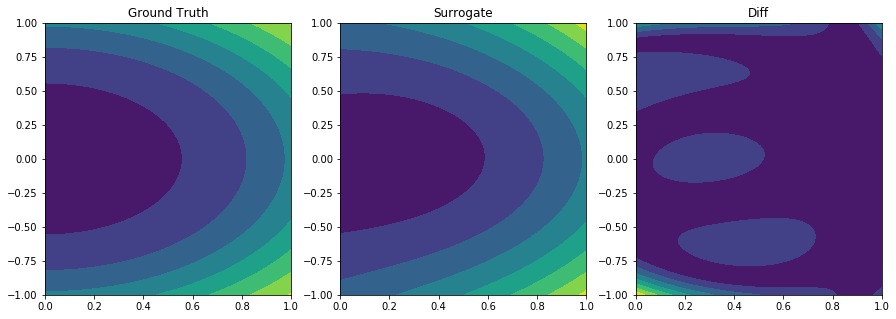

In [13]:
def train_poly_ransac(X):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import RANSACRegressor
    from sklearn.pipeline import Pipeline
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                      ('linear', RANSACRegressor())])
    return model.fit(X[0:2,:].T, X[2,:])

reg_poly_ransac = train_poly_ransac(X)
plot_reg(reg_poly_ransac)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


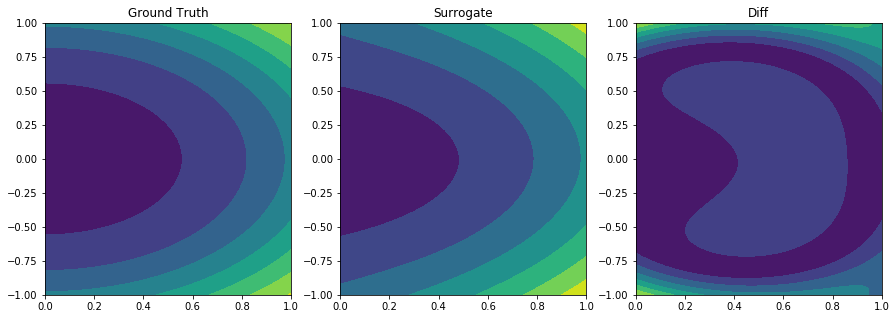

In [14]:
def train_poly_sgd(X):
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import SGDRegressor
    from sklearn.pipeline import Pipeline
    model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                      ('linear', SGDRegressor())])
    return model.fit(X[0:2,:].T, X[2,:])

reg_poly_sgd = train_poly_sgd(X)
plot_reg(reg_poly_sgd)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


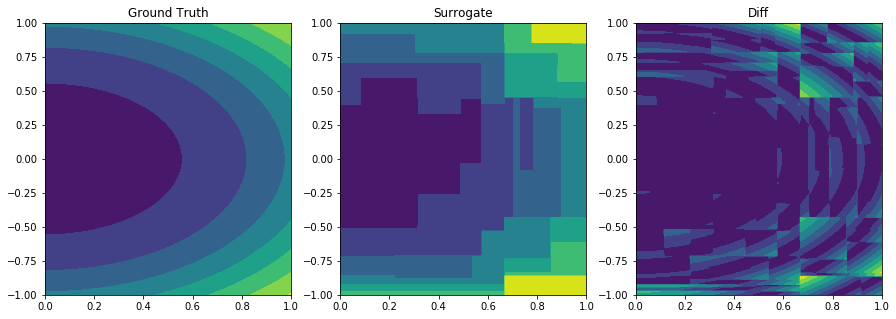

In [15]:
def train_tree(X):
    from sklearn.tree import DecisionTreeRegressor
    return DecisionTreeRegressor().fit(X[0:2,:].T, X[2,:])

reg_tree = train_tree(X)
plot_reg(reg_tree)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


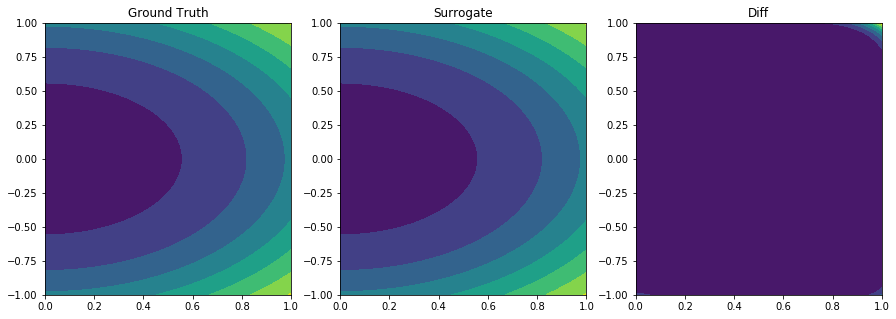

In [16]:
def train_gpr(X):
    from sklearn.gaussian_process import GaussianProcessRegressor
    return GaussianProcessRegressor().fit(X[0:2,:].T, X[2,:])

reg_gpr = train_gpr(X)
plot_reg(reg_gpr)

<ipython-input-9-195f47548bc9>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(131)


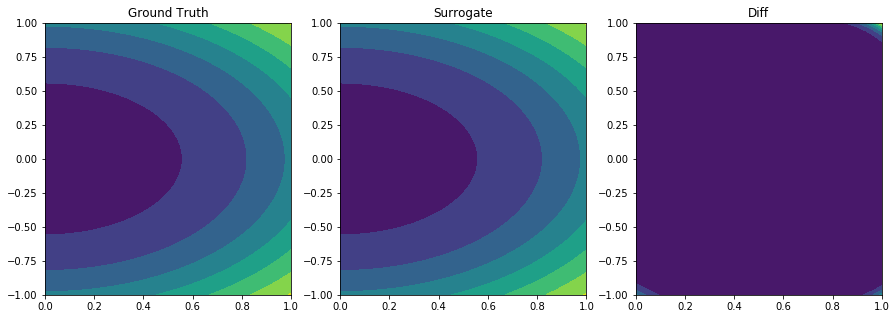

In [17]:
def train_krr(X):
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF
    return GaussianProcessRegressor(kernel=RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))).fit(X[0:2,:].T, X[2,:])

reg_krr = train_krr(X)
plot_reg(reg_krr)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (100 x 100 mtx) ...
         Performing LU fact. (100 x 100 mtx) - done. Time (sec):  0.0186312
      Initializing linear solver - done. Time (sec):  0.0187843
      Solving linear system (col. 0) ...
         Back solving (100 x 100 mtx) ...
         Back solving (100 x 100 mtx) - done. Time (sec):  0.0004466
      Solving linear system (col. 0) - done. Time (sec):  0.0005286
   Training - done. Time (sec):  0.0209098
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 65536
   
   Predictin

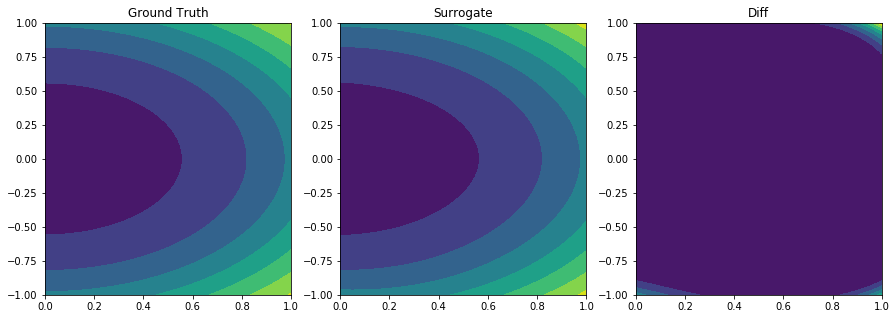

In [20]:
def train_rbf(X):
    from smt.surrogate_models import RBF
    reg = RBF(d0=5)
    reg.set_training_values(X[0:2,:].T, X[2,:])
    reg.train()
    return reg

def plot_reg_stm(reg):
    n_steps = 256
    axes = [np.linspace(dim_low, dim_high, n_steps) for (dim_low, dim_high) in domain]
    xx, yy = np.meshgrid(axes[0], axes[1])
    zz = reg.predict_values(np.c_[xx.ravel(), yy.ravel()]).reshape((n_steps, n_steps))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    ax1 = plt.subplot(131)
    plt.title('Ground Truth')
    zz_gt = plot_gt()

    ax2 = plt.subplot(132, sharey=ax1)
    plt.title('Surrogate')
    h = plt.contourf(xx, yy, zz)

    ax2 = plt.subplot(133, sharey=ax2)
    plt.title('Diff')
    h = plt.contourf(xx, yy, np.abs(zz - zz_gt))

reg_rbf = train_rbf(X)
plot_reg_stm(reg_rbf)

___________________________________________________________________________
   
                                    IDW
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  0.0001509
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 65536
   
   Predicting ...
   Predicting - done. Time (sec):  0.1925299
   
   Prediction time/pt. (sec) :  0.0000029
   
<ipython-input-20-e4a8074d108d>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to e

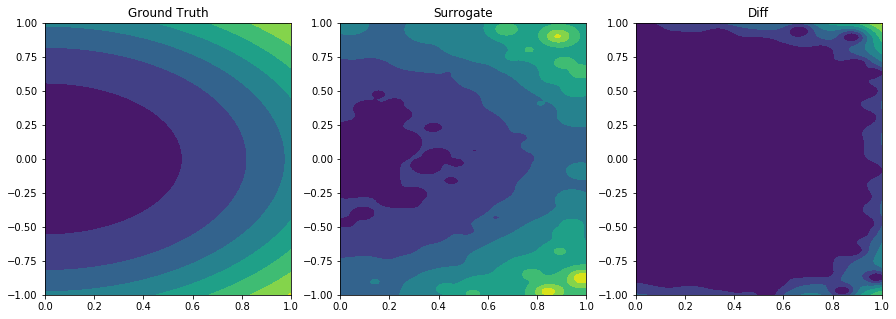

In [25]:
def train_idw(X):
    from smt.surrogate_models import IDW
    reg = IDW(p=2)
    reg.set_training_values(X[0:2,:].T, X[2,:])
    reg.train()
    return reg

reg_idw = train_idw(X)
plot_reg_stm(reg_idw)

___________________________________________________________________________
   
                                   RMTB
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Pre-computing matrices ...
         Computing dof2coeff ...
         Computing dof2coeff - done. Time (sec):  0.0000083
         Initializing Hessian ...
         Initializing Hessian - done. Time (sec):  0.0011733
         Computing energy terms ...
         Computing energy terms - done. Time (sec):  0.0068438
         Computing approximation terms ...
         Computing approximation terms - done. Time (sec):  0.0021665
      Pre-computing matrices - done. Time (sec):  0.0111735
      Solving for degrees of freedom ...
         Solving initial startup problem (n=400) ...
            Solving for output 0 ...
      

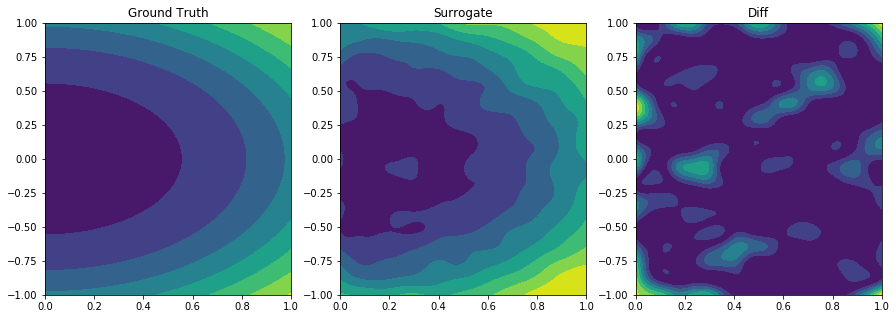

In [30]:
def train_rmtb(X):
    from smt.surrogate_models import RMTB
    reg = RMTB(xlimits=np.array([list(domain[0]), list(domain[1])], dtype=np.double),
        order=4,
        num_ctrl_pts=20,
        energy_weight=1e-15,
        regularization_weight=0.0,
    )
    reg.set_training_values(X[0:2,:].T, X[2,:])
    reg.train()
    return reg

reg_rmtb = train_rmtb(X)
plot_reg_stm(reg_rmtb)